# NGBoost やってみたメモ

* modelのチューニングはきちんとやっていません。なのでどちらが性能がいいかはわかりませんが、えいやっと使った感触ではこれくらいのデータなら遜色なかったです。
* 分布が算出できるのは使いどころがあるかもですね。


In [1]:
# basic libraries
import pandas as pd
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# pandas formatting
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# ngboost
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from ngboost.distns import Normal, LogNormal

# skleran
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# lightgbm
import lightgbm as lgb

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data preparation

In [3]:
X, y = load_boston(True)
rd.seed(71)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# LightGBM model

In [4]:
%%time
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
model = lgb.train({'objective': 'regression', 
           'metric': "mse",
           'learning_rate': 0.01,
           'seed': 71},
            lgb_train, 
            num_boost_round=99999,
            valid_sets=[lgb_valid], 
            early_stopping_rounds=100, 
            verbose_eval=500)

y_pred_lgb = model.predict(data=X_valid)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 10.8615
[1000]	valid_0's l2: 10.0345
[1500]	valid_0's l2: 9.66004
Early stopping, best iteration is:
[1651]	valid_0's l2: 9.57796
CPU times: user 6.74 s, sys: 11.6 s, total: 18.3 s
Wall time: 7.73 s


# NGBoost model

In [5]:
%%time
rd.seed(71)
ngb = NGBoost(Base=default_tree_learner, Dist=Normal, #Normal, LogNormal
              Score=MLE(), natural_gradient=True, verbose=False, )
ngb.fit(X_train, y_train, X_val=X_valid, Y_val=y_valid)

y_preds = ngb.predict(X_valid)
dist_obj = ngb.pred_dist(X_valid)

# test Mean Squared Error
test_MSE = mean_squared_error(y_preds, y_valid)
print('ngb Test MSE', test_MSE)

#test Negative Log Likelihood
test_NLL = -dist_obj.logpdf(y_valid.flatten()).mean()
print('ngb Test NLL', test_NLL)

ngb Test MSE 9.533862361491169
ngb Test NLL 3.8760352
CPU times: user 6.55 s, sys: 1.64 s, total: 8.19 s
Wall time: 5.59 s


# Draw result graph
**point**  
* NGBoostは分布を表示できる（今回は正規分布）
* グラフを目視で見た感想としてはLightGBMがgtに近いものもあれば、NGBoostがgtに近いケースもあり、五分五分？

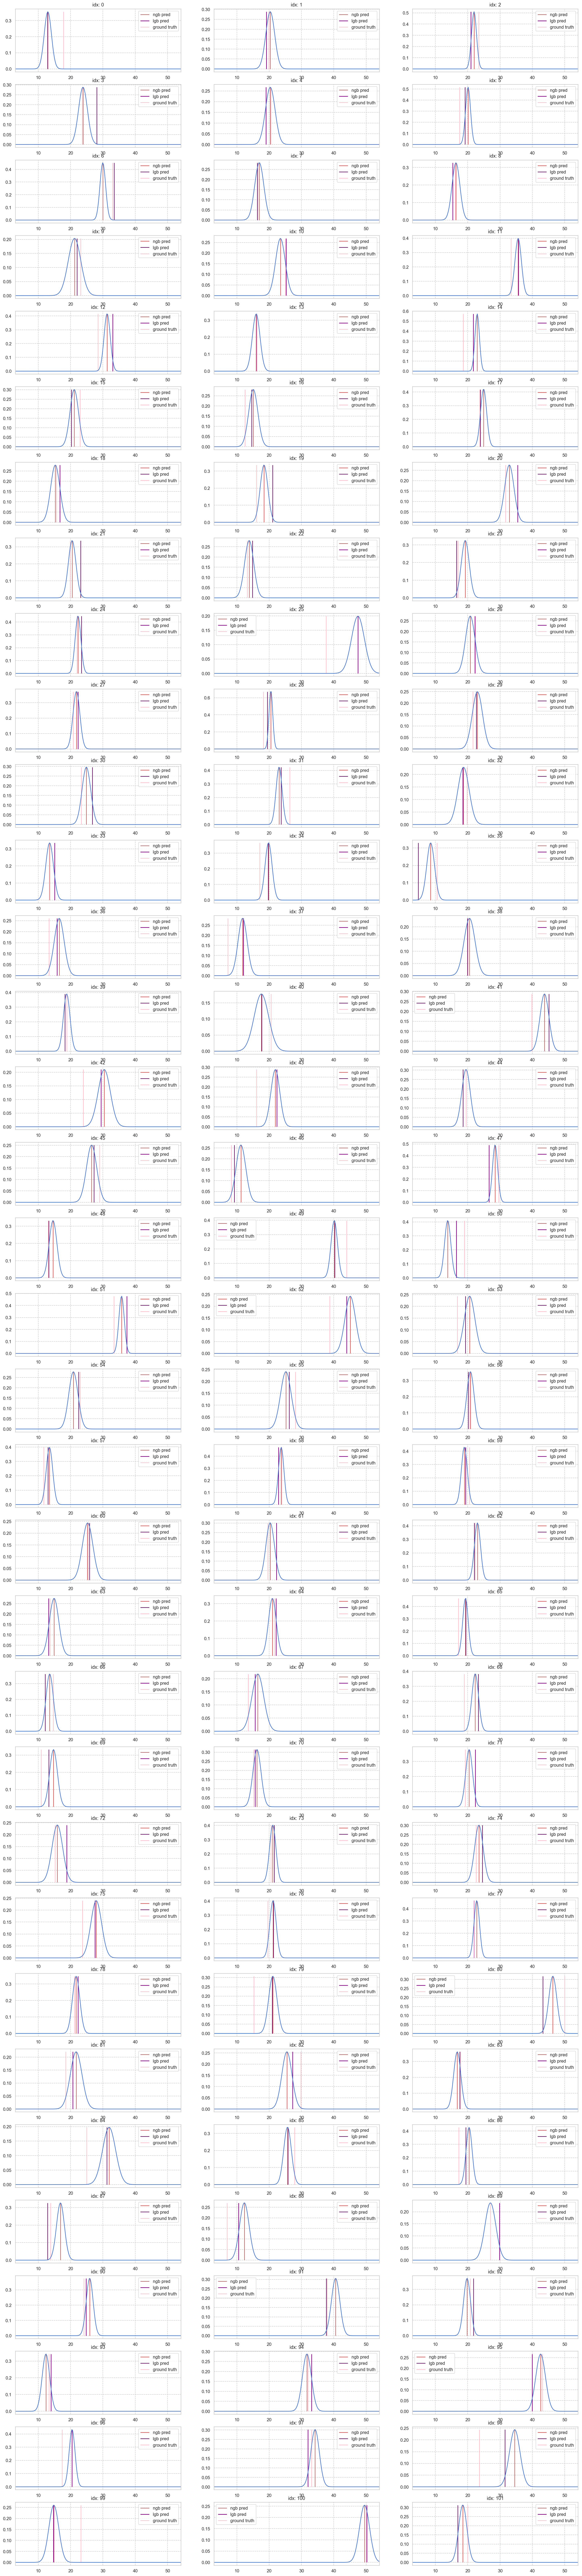

In [6]:
offset = np.ptp(y_preds)*0.1
xx = np.linspace(min(y_valid)-offset, max(y_valid)+offset, 200)

y_dist = []
y_cdf = []
for y in xx:
    y_dist += [dist_obj.pdf(y)]
    y_cdf += [dist_obj.cdf(y)]

plt.figure(figsize=(25, 120))
for idx in tqdm(np.arange(X_valid.shape[0])):
    
    y_pdf = [float(y_dist[i][idx]) for i in range(len(xx))]
    
    plt.subplot(35, 3, idx+1)
    plt.plot(xx, y_pdf)
    
    plt.vlines(y_preds[idx], 0, max(y_pdf), "r", label="ngb pred")
    plt.vlines(y_pred_lgb[idx], 0, max(y_pdf), "purple", label="lgb pred")
    plt.vlines(y_valid[idx], 0, max(y_pdf), "pink", label="ground truth")
    plt.legend(loc="best")
    plt.title(f"idx: {idx}")
    plt.xlim(xx[0], xx[-1])
plt.show()

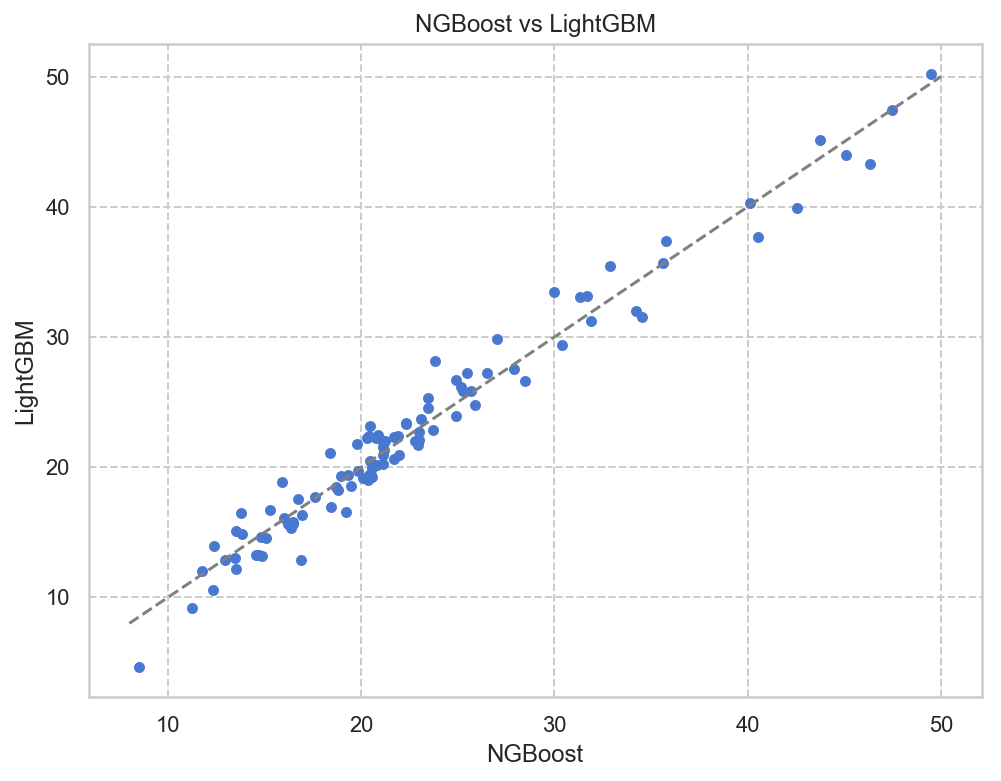

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_preds, y=y_pred_lgb, s=20)
plt.plot([8,50], [8,50], color="gray", ls="--")
plt.xlabel("NGBoost")
plt.ylabel("LightGBM")
plt.title("NGBoost vs LightGBM")
plt.show()

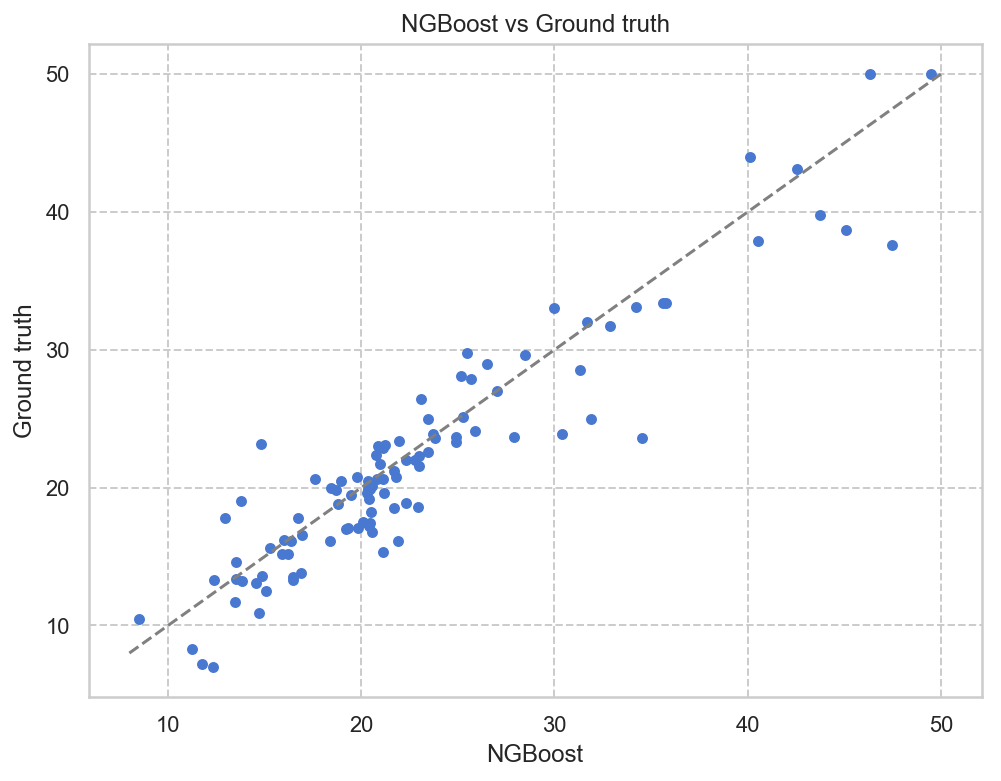

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_preds, y=y_valid, s=20)
plt.plot([8,50], [8,50], color="gray", ls="--")
plt.xlabel("NGBoost")
plt.ylabel("Ground truth")
plt.title("NGBoost vs Ground truth")
plt.show()

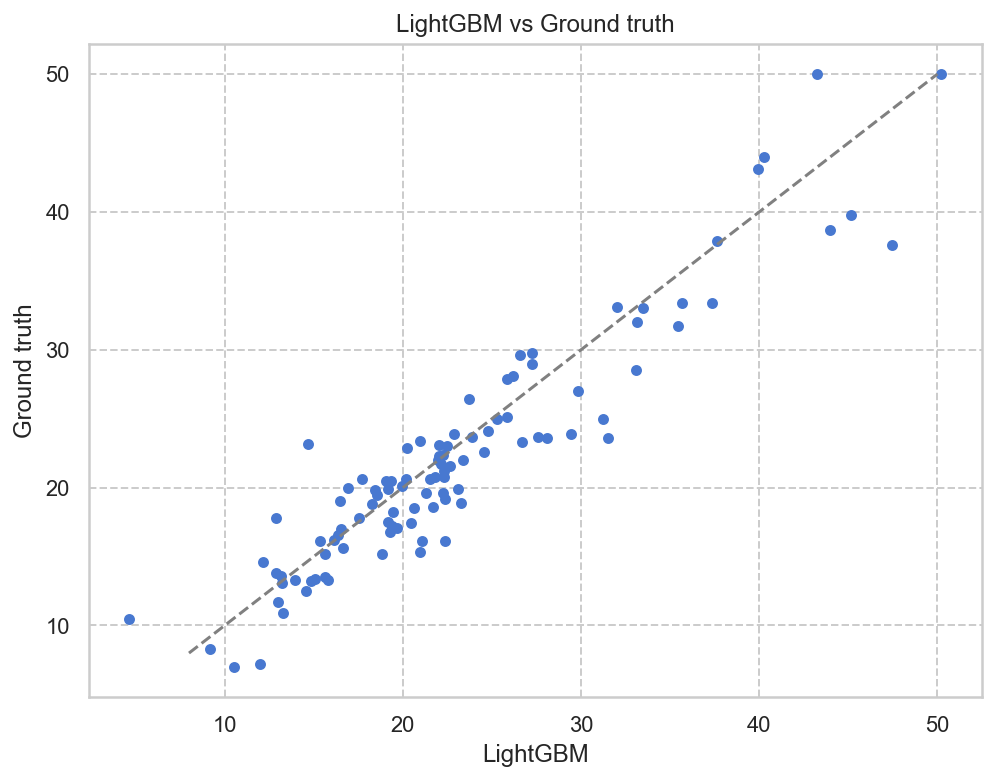

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_pred_lgb, y=y_valid, s=20)
plt.plot([8,50], [8,50], color="gray", ls="--")
plt.xlabel("LightGBM")
plt.ylabel("Ground truth")
plt.title("LightGBM vs Ground truth")
plt.show()